# Anisotropic Model Merger Rate Sampler

In [1]:
import bilby as bb
import gwpopulation as gwpop
import matplotlib.pyplot as plt
import pandas as pd
import jax
from bilby.core.prior import PriorDict, Uniform
import jax_healpy as hp
gwpop.set_backend("jax")

xp = gwpop.utils.xp

%matplotlib inline
print(jax.devices())

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2)]


# Load Posteriors

In [ ]:
Posteriors = list()
import pickle

# Load the pickled list of dictionaries
with open("O3a_FINAL_parameter_posteriors.pkl", "rb") as f:
    raw_event_data = pickle.load(f)

# Convert each event's dictionary into a DataFrame
for event in raw_event_data:
    # Remove the event name key — we'll store it as metadata instead
    event_name = event.pop("event", None)
    df = pd.DataFrame(event)
    df.attrs["event"] = event_name  # Store event label as metadata
    Posteriors.append(df)

with open("O3b_FINAL_parameter_posteriors.pkl", "rb") as f:
    raw_event_data = pickle.load(f)

# Convert each event's dictionary into a DataFrame
for event in raw_event_data:
    # Remove the event name key — we'll store it as metadata instead
    event_name = event.pop("event", None)
    df = pd.DataFrame(event)
    df.attrs["event"] = event_name  # Store event label as metadata
    Posteriors.append(df)

# Filter events with too few samples
Posteriors_filtered = [df for df in Posteriors if len(df["mass_1"]) >= 2000]

# Delete remaining NS or mass gap stragglers
del Posteriors_filtered[67]
del Posteriors_filtered[53]
del Posteriors_filtered[46]
del Posteriors_filtered[26]

# Remove non-numerical entries to prevent errors
for i in range(0, len(Posteriors_filtered)):
    del Posteriors_filtered[i]["full_event"] 

print(len(Posteriors_filtered))

67


# Load Injections

In [ ]:
from gwpopulation_pipe.vt_helper import load_injection_data
import h5py

def load_injection_data_with_sky(vt_file, ifar_threshold=1, snr_threshold=10):
    # Call your existing standard function to get the injections dict (VTData or dict)
    injections = load_injection_data(vt_file, ifar_threshold, snr_threshold)
    
    # Open the file again to extract sky location arrays if present
    with h5py.File(vt_file, "r") as ff:
        # Try common keys for sky position in injections or events group
        ra = None
        dec = None
        if "injections" in ff and "right_ascension" in ff["injections"]:
            ra = xp.array(ff["injections"]["right_ascension"][()])
            dec = xp.array(ff["injections"]["declination"][()])
        elif "events" in ff and "right_ascension" in ff["events"].dtype.names:
            ra = xp.array(ff["events"]["right_ascension"][()])
            dec = xp.array(ff["events"]["declination"][()])
        
        
        if ra is not None and dec is not None:
            # Match the length by slicing or by assuming same order as injections.mass_1
            n = len(injections.mass_1)
            injections.ra = ra[:n]
            injections.dec = dec[:n]
        else:
            print("Warning: RA/DEC not found in the injection file.")

    return injections

injections = load_injection_data_with_sky(
    "/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12.hdf5", # Full O3 run
    #"/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12-1238166018-15843600.hdf5", # O3a only
    ifar_threshold=1.0,
    snr_threshold=10.0
)

injection_dict = dict(injections)
injection_dict["ra"] = injections.ra
injection_dict["dec"] = injections.dec

# Convert to float64 to prevent errors
def convert_vtdata_to_float64(vtdata):
    for key in vtdata.keys():
        val = vtdata[key]
        if isinstance(val, (xp.ndarray,)):
            vtdata[key] = val.astype(xp.float64)
    return vtdata

# Usage
injections = convert_vtdata_to_float64(injection_dict)

20:07 bilby INFO    : Loading VT data from /data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12.hdf5.


# Define sky model in terms of 12 pixels and 3 Euler angles

In [ ]:
from jax.scipy.spatial.transform import Rotation as R

Npix = 12

# Sky model as function of ra and dec data, 11 pixel weights, and 3 euler angles (ZYZ convention)
def sky_shape_model(dataset, 
                    w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, a, b, c):
    ra = dataset["ra"]
    dec = dataset["dec"]

    # Convert to co-latitude and longitude
    theta = xp.pi / 2 - dec
    phi = ra

    # Flatten arrays for healpy computations
    theta_flat = theta.flatten()
    phi_flat = phi.flatten()

    # get sky position vectors on healpy map
    vec = hp.ang2vec(theta_flat, phi_flat)

    # Define rotation matrix from Euler angles
    rot = R.from_euler("ZYZ", [a, b, c], degrees=False)
    vec_rot = rot.apply(vec)

    # Rotate all data by matrix R (equiv to rotating maps by R^{-1})
    theta_rot, phi_rot = hp.vec2ang(vec_rot)
    pix = hp.ang2pix(1, theta_rot, phi_rot)

    # Weights sum to 1, so last weight is uniquely determined by first 11
    weights_partial = xp.array([w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10])
    w_N = 1 - xp.sum(weights_partial)
    weights = xp.concatenate([weights_partial, xp.array([w_N])])

    # Weights need normalised to 4 pi or else rate posterior is roughly 12 times too large
    probs_flat = weights[pix] * 4 * xp.pi

    # unflatten probs to match input data shape
    probs = probs_flat.reshape(ra.shape)

    return probs



# Define Priors
Need to find good numbers and replace with delta functions for all but sky model.

# Firstly, create Dirichlet prior to uniformly sample the N-1 Simplex:

In [ ]:
from bilby.core.prior.dict import DirichletPriorDict, ConditionalPriorDict

# Create the DirichletPriorDict for Npix weights (Npix-1 parameters)
dirichlet_prior_dict = DirichletPriorDict(n_dim=Npix, label="w_")


In [6]:
from bilby.core.prior import DeltaFunction, Exponential, Uniform, Sine, PowerLaw

# Make conditional dict to retain sampling constraints
priors = ConditionalPriorDict(dirichlet_prior_dict)

# mass
priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
priors["mmin"] = Uniform(minimum=2, maximum=2.5, latex_label="$m_{\\min}$")
priors["mmax"] = Uniform(minimum=80, maximum=100, latex_label="$m_{\\max}$")
priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
priors["sigpp"] = Uniform(minimum=1, maximum=10, latex_label="$\\sigma_{m}$")
priors["gaussian_mass_maximum"] = 100
# spin
priors["amax"] = 1
priors["alpha_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\alpha_{\\chi}$")
priors["beta_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\beta_{\\chi}$")
priors["xi_spin"] = Uniform(minimum=0, maximum=1, latex_label="$\\xi$")
priors["sigma_spin"] = Uniform(minimum=0.3, maximum=4, latex_label="$\\sigma$")
# Cosmology
priors["lamb"] = Uniform(minimum=-1, maximum=10, latex_label="$\\lambda_{z}$")


# --- Sky model: Euler angles ---
# alpha and gamma: uniform over [0, 360)
priors["a"] = Uniform(minimum=0.0, maximum=2*xp.pi, latex_label = "$\\alpha_{e}$")
priors["c"] = Uniform(minimum=0.0, maximum=2*xp.pi, latex_label = "$\\gamma_{e}$")

#beta: sine prior over [0, pi] to ensure isotropy in inclination
priors["b"] = Sine(minimum=0.0, maximum=xp.pi, latex_label = "$\\beta_{e}$")

# Define combined model, selection function, and likelihood

In [7]:
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel

# Wrap models into a NonCachingModel object
model = NonCachingModel(
    model_functions=[
        gwpop.models.mass.two_component_primary_mass_ratio,
        gwpop.models.spin.iid_spin,
        gwpop.models.redshift.PowerLawRedshift(cosmo_model="Planck15"),
        sky_shape_model,
    ],
)

# Define vt function
vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(Posteriors_filtered))

# Define hyperlikelihood
likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=Posteriors_filtered,
    hyper_prior=model,
    selection_function=vt,
    max_samples = 2000,
)

20:08 bilby INFO    : No prior values provided, defaulting to 1.


# Test likelihood and set up JIT compilation

In [9]:
# Sample from the prior
parameters = priors.sample()
likelihood.parameters.update(parameters)
likelihood.log_likelihood_ratio()
%time print(likelihood.log_likelihood_ratio())

# Define just-in-time compiled version (uses JAX)
jit_likelihood = JittedLikelihood(likelihood)
jit_likelihood.parameters.update(parameters)
%time print(jit_likelihood.log_likelihood_ratio())
%time print(jit_likelihood.log_likelihood_ratio())

-353.16118833773214
CPU times: user 569 ms, sys: 175 ms, total: 744 ms
Wall time: 551 ms
-353.16118833773214
CPU times: user 18.6 s, sys: 823 ms, total: 19.5 s
Wall time: 8.7 s
-353.16118833773214
CPU times: user 10.2 ms, sys: 2.81 ms, total: 13 ms
Wall time: 6.13 ms


In [10]:
result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=1000,
    label="O3_ANISO_1000",
    outdir="Full_tests",
    sample="acceptance-walk",
    naccept=20,
    save="pkl",
)



18:43 bilby INFO    : Running for label 'O3_ANISO_1000', output will be saved to 'Full_tests'
/data/wiay/undergrads/2640787g/BHIsotropy/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
18:43 bilby INFO    : Analysis priors:
18:43 bilby INFO    : w_0=DirichletElement(order=0, n_dimensions=12, label='w_')
18:43 bilby INFO    : w_1=DirichletElement(order=1, n_dimensions=12, label='w_')
18:43 bilby INFO    : w_2=DirichletElement(order=2, n_dimensions=12, label='w_')
18:43 bilby INFO    : w_3=DirichletElement(order=3, n_dimensions=12, label='w_')
18:43 bilby INFO    : w_4=DirichletElement(order=4, n_dimensions=12, label='w_')
18:43 bilby INFO    : w_5=DirichletElement(order=5, n_dimensions=12, label='w_')
18:

26450it [00:00, ?it/s]

18:52 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
19:10 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
19:29 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
19:47 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
20:05 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
20:24 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
20:42 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
21:00 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
21:18 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
21:37 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
21:55 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO_1000_resume.pickle
22:13 bilby INFO    : Written checkpoint file Full_tests/O3_ANISO

01:19 bilby INFO    : Summary of results:
nsamples: 9740
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.155
ln_bayes_factor: -242.896 +/-  0.155



In [14]:
# Load the result file (replace with your actual filename)
result = bb.result.read_in_result('Full_tests/O3_ANISO_test_result.pkl')

# List of parameters to exclude
exclude_params = [
    "alpha", "beta", "mmin", "mmax", "lam", "mpp", "sigpp", "gaussian_mass_maximum",
    "amax", "alpha_chi", "beta_chi", "xi_spin", "sigma_spin", "lamb", "log_likelihood", "prior"
]

# Get the list of parameters to include in the corner plot
plot_params = [param for param in result.posterior.columns if param not in exclude_params]

# Make the corner plot
result.plot_corner()

# Show the plot
plt.show()

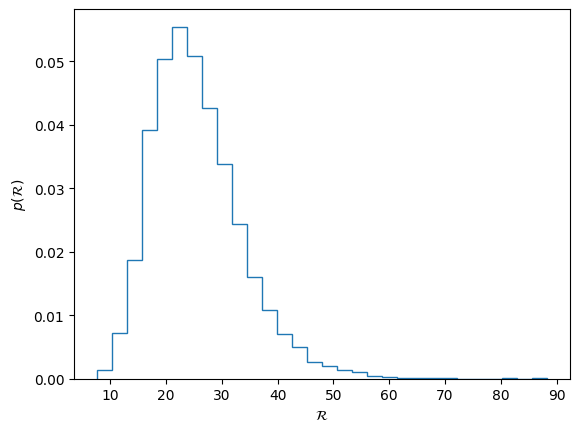

In [9]:
result = bb.result.read_in_result('Full_tests/O3_ANISO_1000_result.pkl')

rates = list()
for ii in range(len(result.posterior)):
    likelihood.parameters.update(dict(result.posterior.iloc[ii]))
    rates.append(float(likelihood.generate_rate_posterior_sample()))
result.posterior["rate"] = rates

plt.hist(rates, bins=30, histtype="step", density=True)
plt.xlabel("${\\cal R}$")
plt.ylabel("$p({\\cal R})$")
plt.show()
plt.close()

Rate median: 2.360e+01
68% credible interval: [1.721e+01, 3.246e+01]
Reported as: 2.360e+01 (+8.865e+00/-6.392e+00)


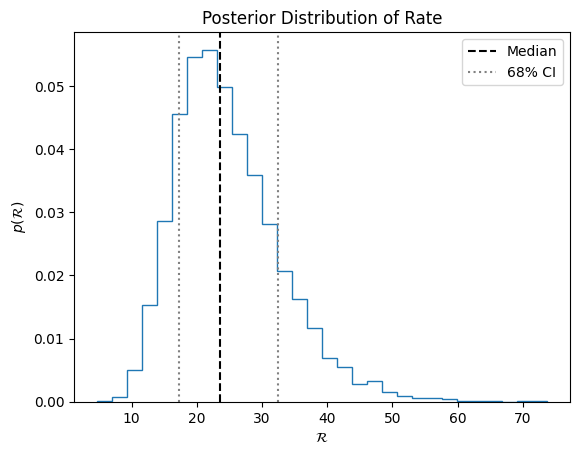

In [3]:
import bilby as bb
import matplotlib.pyplot as plt
import numpy as np

# Load result
result = bb.result.read_in_result('Full_tests/O3_ISO_1000_result_updated.pkl')

# Extract posterior samples of the rate
rates = result.posterior["rate"]

# Compute median and 1-sigma (68%) credible interval
median = np.median(rates)
lower, upper = np.percentile(rates, [16, 84])

# Print in standard format
print(f"Rate median: {median:.3e}")
print(f"68% credible interval: [{lower:.3e}, {upper:.3e}]")
print(f"Reported as: {median:.3e} (+{upper - median:.3e}/-{median - lower:.3e})")

# Plot posterior histogram
plt.hist(rates, bins=30, histtype="step", density=True)
plt.xlabel("${\\cal R}$")
plt.ylabel("$p({\\cal R})$")
plt.title("Posterior Distribution of Rate")
plt.axvline(median, color='k', linestyle='--', label="Median")
plt.axvline(lower, color='gray', linestyle=':', label="68% CI")
plt.axvline(upper, color='gray', linestyle=':')
plt.legend()
plt.show()
plt.close()


# Euler Angle Correction



In [78]:
import healpy as hp
import numpy as np
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

result = bb.result.read_in_result('Full_tests/O3_ANISO_1000_result_updated.pkl')
# Setup
Npix = 12
nside = hp.npix2nside(Npix)
npix = hp.nside2npix(nside)

n_samples = len(result.posterior)
pixel_rate_posteriors = np.zeros((n_samples, Npix))

# Get pixel center vectors in the model basis
vec_model = np.asarray(hp.pix2vec(nside, np.arange(Npix)))  # shape (3, 12)
vec_model = vec_model.T  # shape (12, 3)

# Loop through posterior samples
for i in tqdm(range(n_samples)):
    # Get sampled weights
    weights = [result.posterior[f"w_{j}"].iloc[i] for j in range(Npix - 1)]
    w_last = 1.0 - sum(weights)
    weights.append(w_last)
    weights = np.asarray(weights)

    # Total rate for this sample
    R_tot = result.posterior["rate"].iloc[i]
    rates_rotated = weights * R_tot

    # Euler angles
    alpha = result.posterior["a"].iloc[i]
    beta = result.posterior["b"].iloc[i]
    gamma = result.posterior["c"].iloc[i]

    # Build rotation to orient each sample map correctly
    rotation = R.from_euler("ZYZ", [alpha, beta, gamma], degrees=False)
    vec_celestial = rotation.inv().apply(vec_model)  # shape (12, 3)

    # Convert rotated vectors to spherical angles
    theta_new, phi_new = hp.vec2ang(vec_celestial.T)

    # Interpolate to get celestial frame rates
    map_rotated = np.zeros(npix)
    map_rotated[:Npix] = rates_rotated
    pix_indices = hp.vec2pix(nside, vec_celestial[:, 0], vec_celestial[:, 1], vec_celestial[:, 2])

    pixel_rate_posteriors[i, :] = 0.0
    for j, pix in enumerate(pix_indices):
        pixel_rate_posteriors[i, pix] += rates_rotated[j]




100%|██████████| 9740/9740 [00:02<00:00, 4805.61it/s]


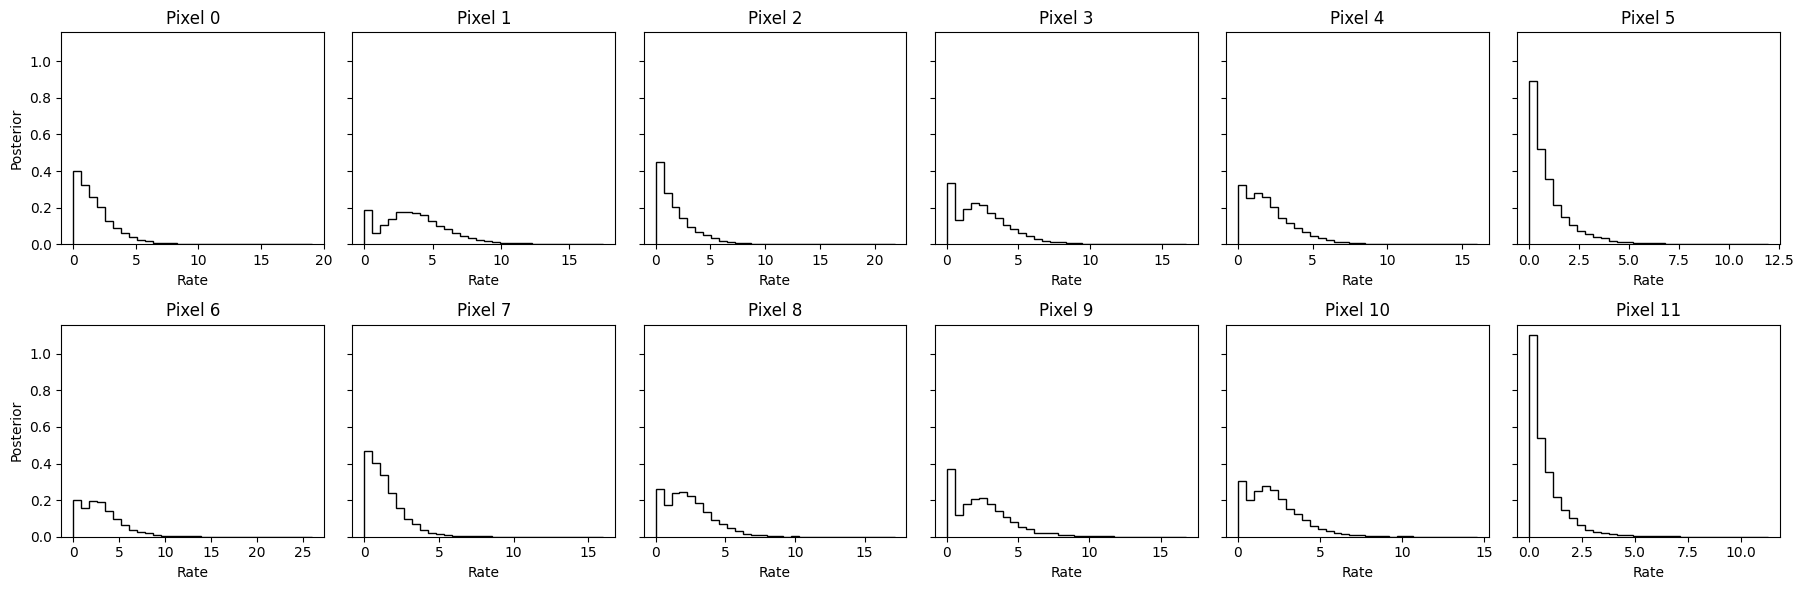

In [79]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharey=True)

for i in range(12):
    ax = axes[i // 6, i % 6]
    ax.hist(pixel_rate_posteriors[:, i], bins=30, histtype='step', color='black', density=True)
    ax.set_title(f"Pixel {i}")
    ax.set_xlabel("Rate")
    if i % 6 == 0:
        ax.set_ylabel("Posterior")

plt.tight_layout()
plt.show()


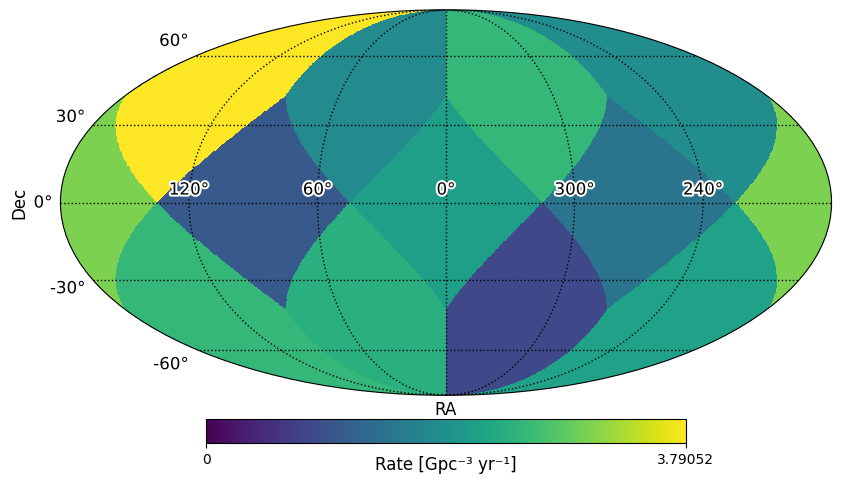

25.562297844782854


In [ ]:
from matplotlib import patheffects
from healpy.newvisufunc import projview, newprojplot
import matplotlib.collections as mcoll



# Step 1: Mean rate in each pixel (celestial frame)
mean_rates = np.mean(pixel_rate_posteriors, axis=0)

# Step 2: Create full HEALPix map
nside = hp.npix2nside(12)
npix = hp.nside2npix(nside)
map_to_plot = np.full(npix, hp.UNSEEN)  # Fill all with unseen
map_to_plot[:12] = mean_rates           # Set only the 12 pixels we used

# Step 3: Mollweide plot
# hp.mollview(
#     map_to_plot,
#     title="Mean Merger Rate per Pixel (Celestial Frame)",
#     unit="Rate [Gpc⁻³ yr⁻¹]",
#     cmap="viridis",
#     min=0,
#     #max=np.max(mean_rates)
# )
# hp.graticule()

hp.projview(
    map_to_plot,
    coord='C',
    projection_type='mollweide',
    graticule=True,
    graticule_labels=True,
    title="",
    unit="Rate [Gpc⁻³ yr⁻¹]",
    cmap='viridis',
    xlabel='RA',
    ylabel='Dec',
    cbar=True,
    flip='astro',
    min=0,
)

ax = plt.gca()

# Configure matplotlib Mollweide axes for your own grid and labels
ax.grid(True, color='black', linestyle=':', linewidth=1)

# Customize tick labels: black with subtle white stroke
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color('black')
    label.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])




plt.show()



print(np.sum(mean_rates))

# Euler Correction with smoothing onto Nside=64 basis

  0%|          | 0/9740 [00:00<?, ?it/s]

100%|██████████| 9740/9740 [00:13<00:00, 729.40it/s]
/data/wiay/undergrads/2640787g/tmp/pip-build/ipykernel_2811804/3609665902.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')


Total Integrated Rate: 25.562297844782794


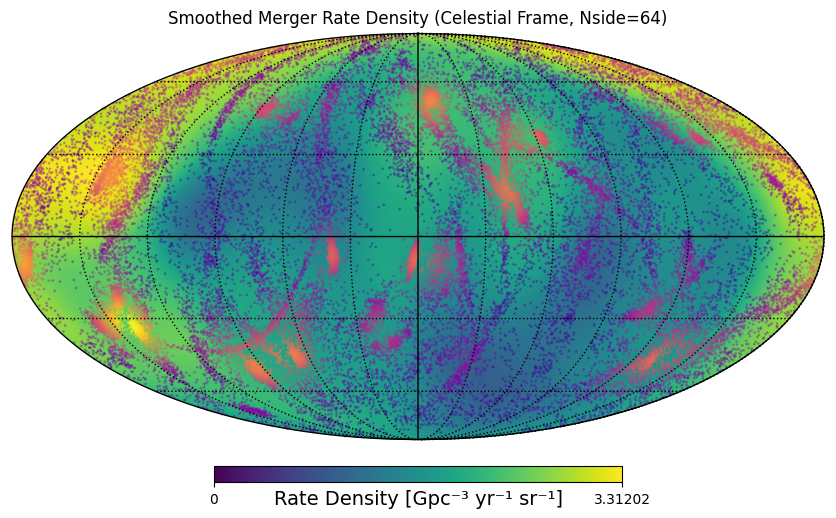

In [81]:
import healpy as hp
import numpy as np
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from scipy.stats import gaussian_kde
from matplotlib import cm
import matplotlib.pyplot as plt  # Required for colormap
import warnings

# === HEALPix Parameters ===
nside_model = 1        # model basis (12 pixels)
nside_target = 64      # high-res common basis
npix_model = hp.nside2npix(nside_model)
npix_target = hp.nside2npix(nside_target)

# Get model pixel center vectors
vec_model = np.asarray(hp.pix2vec(nside_model, np.arange(npix_model))).T  # shape (12, 3)

# High-res map to accumulate results
pdf_map = np.zeros(npix_target)

# === Build Map from Posterior Samples ===
n_samples = len(result.posterior)

for i in tqdm(range(n_samples)):
    # 1. Sample Weights
    weights = [result.posterior[f"w_{j}"].iloc[i] for j in range(npix_model - 1)]
    weights.append(1.0 - sum(weights))
    weights = np.asarray(weights)
    rate = result.posterior["rate"].iloc[i]
    pixel_rates = weights * rate

    # 2. Rotation
    alpha = result.posterior["a"].iloc[i]
    beta  = result.posterior["b"].iloc[i]
    gamma = result.posterior["c"].iloc[i]
    rot = R.from_euler("ZYZ", [alpha, beta, gamma], degrees=False)
    vec_rotated = rot.inv().apply(vec_model)  # shape (12, 3)

    # 3. Distribute Rate to High-Res Pixels
    pixel_radius = hp.max_pixrad(nside_model)
    for j in range(npix_model):
        idx_hit = hp.query_disc(
            nside_target,
            vec_rotated[j],
            pixel_radius,
            inclusive=True,
            fact=4
        )

        if len(idx_hit) > 0:
            contribution = pixel_rates[j] / len(idx_hit)
            pdf_map[idx_hit] += contribution

# 4. Normalize
pdf_map /= n_samples

# 5. Convert to Rate Density (optional)
pix_area_sr = hp.nside2pixarea(nside_target)
rate_density_map = pdf_map / pix_area_sr

# === PREPARE SCATTER PLOT DATA ===
all_ra = []
all_dec = []

for i, df in enumerate(Posteriors_filtered):
    if isinstance(df, dict):
        warnings.warn(f"Posteriors_filtered[{i}] is a dict, expected a DataFrame.")
        continue
    if 'ra' in df.columns and 'dec' in df.columns and not df.empty:
        sampled = df.sample(n=min(500, len(df)), random_state=42)
        all_ra.append(sampled['ra'].values)
        all_dec.append(sampled['dec'].values)
    else:
        warnings.warn(f"Skipping dataframe {i}: missing 'ra'/'dec' or empty.")

if not all_ra or not all_dec:
    raise ValueError("No valid RA/Dec data found in Posteriors_filtered.")

# Concatenate and convert to radians
ra_rad = np.concatenate(all_ra)
dec_rad = np.concatenate(all_dec)

# Convert to theta/phi for Healpy
theta = 0.5 * np.pi - dec_rad
phi = ra_rad

# Convert to Cartesian for KDE
x = np.cos(phi) * np.sin(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(theta)
coords = np.vstack([x, y, z])

# Compute 3D KDE
kde = gaussian_kde(coords)
densities = kde(coords)

# Normalize densities
densities_normalized = (densities - densities.min()) / (densities.max() - densities.min() + 1e-8)

# Map to colors
cmap = cm.get_cmap('plasma')
colors = cmap(densities_normalized)

# === PLOT ===
hp.mollview(
    rate_density_map,
    title="Smoothed Merger Rate Density (Celestial Frame, Nside=64)",
    unit="Rate Density [Gpc⁻³ yr⁻¹ sr⁻¹]",
    cmap="viridis",
    min=0,
    # max=np.percentile(rate_density_map, 99),  # Uncomment to cap high outliers
)

hp.projscatter(theta, phi, lonlat=False, c=colors, s=1, alpha=0.3)
hp.graticule()
print("Total Integrated Rate:", np.sum(pdf_map))


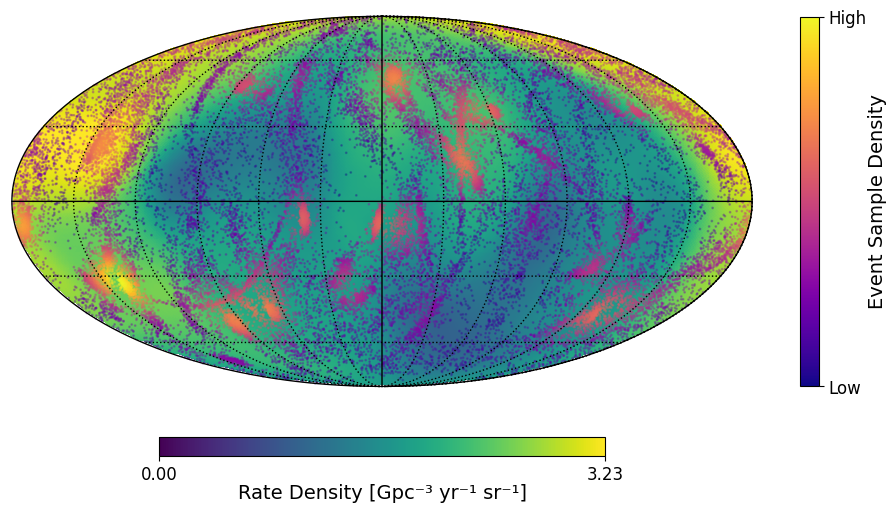

In [72]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import healpy as hp
import numpy as np
from scipy.stats import gaussian_kde

# === Assume these are already in radians ===
# ra, dec = ...  (1D arrays from your sampled posteriors, in radians)

# === Convert to theta/phi (Healpy convention) ===
# theta = 0.5 * np.pi - dec  # theta = pi/2 - dec
# phi = ra                   # phi = ra

# === Convert to 3D Cartesian for KDE ===
x = np.cos(phi) * np.sin(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(theta)
coords = np.vstack([x, y, z])

# === KDE Density Estimation ===
kde = gaussian_kde(coords)
densities = kde(coords)

# === Normalize densities for color mapping ===
densities_normalized = (densities - densities.min()) / (densities.max() - densities.min() + 1e-8)

# === Create figure ===
fig = plt.figure(figsize=(12, 8))

# === Plot healpy map with no default colorbar ===
hp.mollview(
    rate_density_map,
    title="",
    unit="",
    cmap="viridis",
    min=0,
    max=np.percentile(rate_density_map, 99),
    cbar=False,
    hold=True,
)

# === Add scatter overlay ===
hp.projscatter(theta, phi, lonlat=False, c=densities_normalized, cmap='plasma', s=1, alpha=0.3)
hp.graticule()

# === Get current axis used by healpy ===
ax = plt.gca()

# === Vertical colorbar for scatter ===
norm_scatter = Normalize(vmin=0, vmax=1)
sm_scatter = ScalarMappable(cmap='plasma', norm=norm_scatter)
sm_scatter.set_array([])

cbar_scatter = plt.colorbar(sm_scatter, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
cbar_scatter.set_ticks([0, 1])
cbar_scatter.set_ticklabels(["Low", "High"])
cbar_scatter.set_label('Event Sample Density', fontsize=14, labelpad=0.5)
cbar_scatter.ax.tick_params(labelsize=12)

# === Horizontal colorbar for map ===
cbax = inset_axes(
    ax,
    width="60%",
    height="5%",
    loc='lower center',
    bbox_to_anchor=(0.0, -0.18, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

vmin_map = 0
vmax_map = np.percentile(rate_density_map, 99)
norm_map = Normalize(vmin=vmin_map, vmax=vmax_map)
sm_map = ScalarMappable(cmap='viridis', norm=norm_map)
sm_map.set_array([])

cbar_map = plt.colorbar(sm_map, cax=cbax, orientation='horizontal')
cbar_map.set_ticks([vmin_map, vmax_map])
cbar_map.set_ticklabels([f"{vmin_map:.2f}", f"{vmax_map:.2f}"])
cbar_map.set_label("Rate Density [Gpc⁻³ yr⁻¹ sr⁻¹]", fontsize=14, labelpad=0.5)
cbar_map.ax.tick_params(labelsize=12)

# === Final Layout ===
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.show()


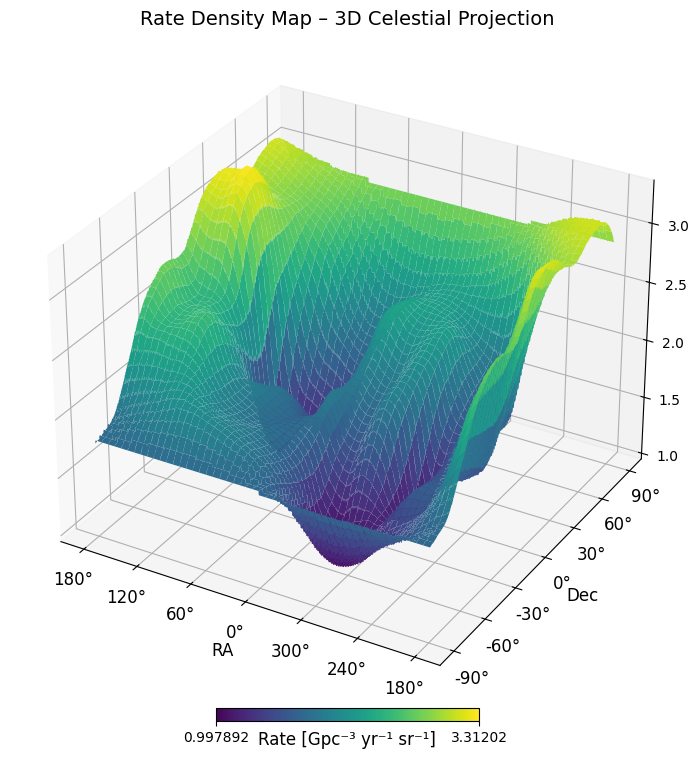

In [82]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# Example map (replace this with your actual rate_density_map)
# rate_density_map = hp.read_map("your_map.fits")
# or:
# rate_density_map = np.array([...])  # Your real map
# For demonstration, create a dummy map:
#nside = 2


# Plot in 3D projection
hp.projview(
    rate_density_map,
    coord=["C"],  # Celestial coords
    hold=False,
    graticule=True,
    graticule_labels=True,
    unit="Rate [Gpc⁻³ yr⁻¹ sr⁻¹]",
    xlabel="RA",
    ylabel="Dec",
    cb_orientation="horizontal",
    projection_type="3d",
    title="Rate Density Map – 3D Celestial Projection",
    flip="astro"
)

plt.show()


# Bayes Factor Calculation

In [1]:
import bilby as bb
import numpy as np
#iso_result = bb.result.read_in_result('outdir/O3_hyper_test_result.pkl')
#aniso_result = bb.result.read_in_result('outdir/O3a_Px12_result.pkl')
iso_result = bb.result.read_in_result('Full_tests/O3_ISO_1000_result.pkl')
aniso_result = bb.result.read_in_result('Full_tests/O3_ANISO_1000_result.pkl')

# define log evidences and errors for isotropic / anisotropic models
iso_log_evid, iso_log_evid_err = iso_result.log_evidence, iso_result.log_evidence_err
aniso_log_evid, aniso_log_evid_err = aniso_result.log_evidence, aniso_result.log_evidence_err

Log_BF_iso, Log_BF_aniso = iso_result.log_bayes_factor, aniso_result.log_bayes_factor

BF = np.exp(Log_BF_iso - Log_BF_aniso)

BF_err = BF * np.sqrt(iso_log_evid_err**2 + aniso_log_evid_err**2)

print("The Bayes factor (ISO/ANISO) is", BF, "+/-", BF_err)


The Bayes factor (ISO/ANISO) is 3.9584932649541003 +/- 0.8331710576044059
